In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 500
NUM_WORKERS = 8

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 20)
        self.fc32 = nn.Linear(256, 20)
        self.fc4 = nn.Linear(20, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))


def eval(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [2]:
def mnist_subset(dataset, classes_to_use):
    # dataset: datasets.MNIST('./', train=False, transform=transforms.ToTensor())
    # classes_to_use: a list of class
    data = dataset.data.numpy()
    targets = dataset.targets.numpy()

    data_to_keep = []
    targets_to_keep = []
    for i in range(len(targets)):
        if targets[i] in classes_to_use:
            data_to_keep.append(data[i])
            targets_to_keep.append(targets[i])

    dataset.data = torch.tensor(np.stack(data_to_keep, axis=0))
    dataset.targets = torch.tensor(np.array(targets_to_keep))
    return dataset

In [3]:
def DKL_gau(mu1, std1, mu2, std2):
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    return torch.log(std2/std1)+(std1.pow(2) + (mu1-mu2).pow(2)) / (2*std2.pow(2)) - 0.5

def recon_till_converge(image_batch, thres=1e-6, return_history=False):
    diff=1e10
    history = [image_batch]
    with torch.no_grad():
        while diff>thres:
            recon_batch, mu, logvar = model(image_batch)
            diff = torch.mean((recon_batch - recon_batch).pow(2))
            if return_history:
                history.append(recon_batch)
            image_batch = recon_batch
    if return_history:
        return recon_batch, history
    else:
        return recon_batch


In [4]:
batch_size=BATCH_SIZE
epochs=50
log_interval=10
seed=1
cuda=True
classes_to_use = [0,1,2,3,4,5,6,7,8,9]

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': True} if cuda else {}

In [5]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
train_dataset = datasets.MNIST('./', train=True, download=True,transform=transforms.ToTensor())
train_dataset = mnist_subset(train_dataset, classes_to_use)
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

# test_dataset = datasets.MNIST('./', train=False, transform=transforms.ToTensor())
# test_dataset = mnist_subset(test_dataset, classes_to_use)
# test_loader = torch.utils.data.DataLoader(test_dataset,
#     batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [7]:
for epoch in range(1, epochs + 1):
    train(epoch)
    eval(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 219.1798
====> Test set loss: 188.2338
====> Epoch: 2 Average loss: 170.5446
====> Test set loss: 150.7288
====> Epoch: 3 Average loss: 142.7854
====> Test set loss: 134.5330
====> Epoch: 4 Average loss: 131.1231
====> Test set loss: 126.2102
====> Epoch: 5 Average loss: 124.2867
====> Test set loss: 120.3190
====> Epoch: 6 Average loss: 119.5887
====> Test set loss: 116.8535
====> Epoch: 7 Average loss: 116.4390
====> Test set loss: 114.4813
====> Epoch: 8 Average loss: 114.0576
====> Test set loss: 112.1927
====> Epoch: 9 Average loss: 112.2737
====> Test set loss: 110.9046
====> Epoch: 10 Average loss: 110.8646
====> Test set loss: 109.5613
====> Epoch: 11 Average loss: 109.7901
====> Test set loss: 108.6722
====> Epoch: 12 Average loss: 108.8396
====> Test set loss: 107.8927
====> Epoch: 13 Average loss: 108.0031
====> Test set loss: 107.1711
====> Epoch: 14 Average loss: 107.2886
====> Test set loss: 106.4476
====> Epoch: 15 Average loss: 106.5777
====

Digits that are not

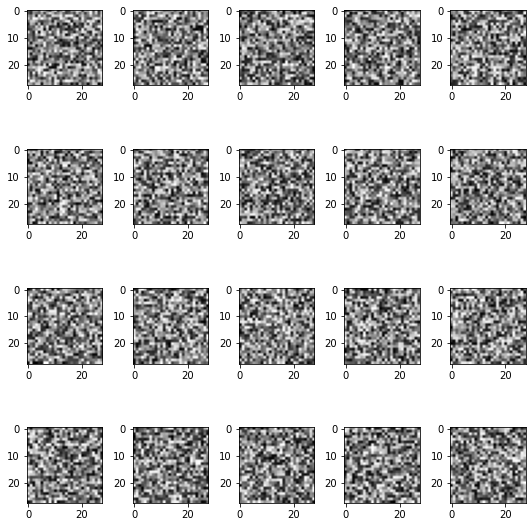

In [25]:
sample = torch.rand((20,28,28)) #TODO: 什么noise？
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

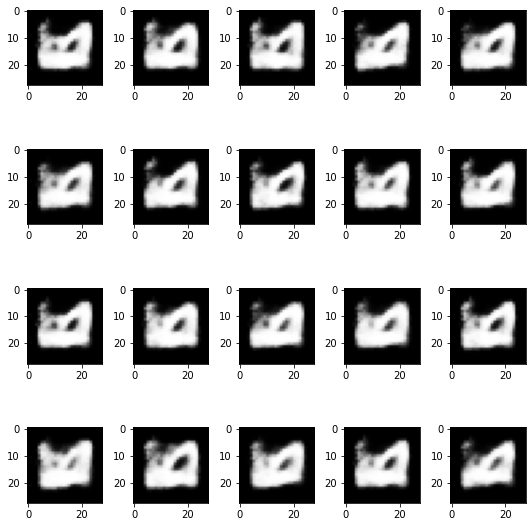

In [26]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

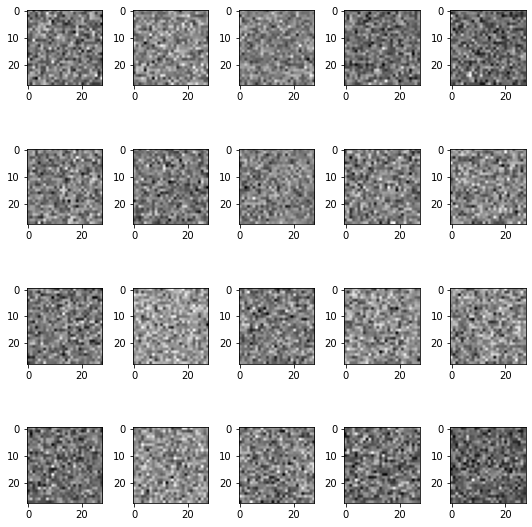

In [34]:
sample = torch.randn((20,28,28)) #TODO: 什么noise？
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

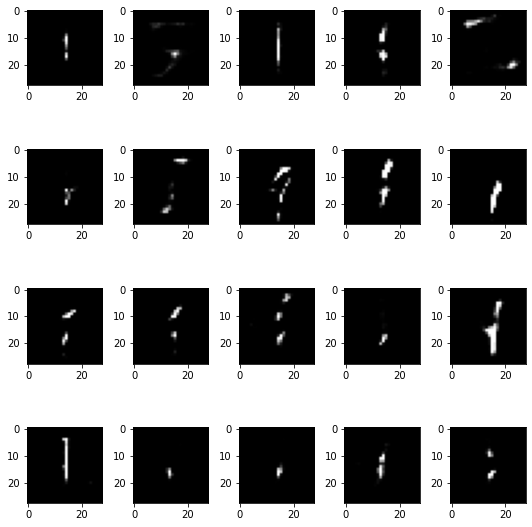

In [35]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

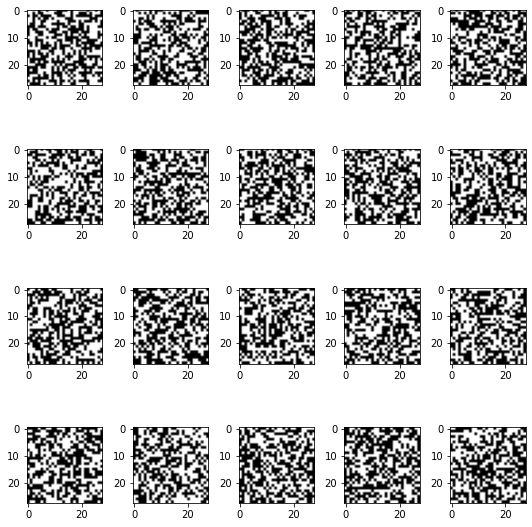

In [29]:
sample = torch.randint(0, 2, (20,28,28)).float() #TODO: 什么noise？
#TODO：有没有double ascend？
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()

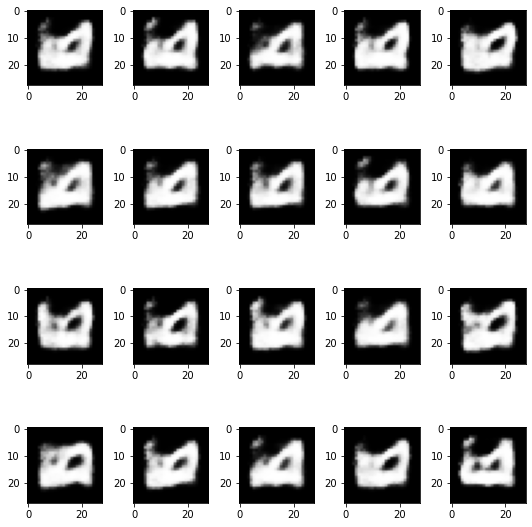

In [30]:
num_row = 4
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(20):
    ax = axes[i//num_col, i%num_col]
    converged_image = recon_till_converge(sample[i:i+1].to(device), thres=1e-5)
    ax.imshow(converged_image[0].cpu().numpy().reshape(28,28), cmap='gray')
plt.tight_layout()
plt.show()